# APRENDIZAJE AUTOMÁTICO
# Práctica 2: Regularización y Selección de Modelos
### Autor: Herce Cruz, Daniel
### NIP:   848884
### Fecha: 15-02-2024

---



## Configuración

In [1]:
%matplotlib inline
try:
  from google.colab import drive
  print("Trabajando en Colab")
  drive.mount('/content/drive')                # Monta tu google drive
  Path = '/content/drive/MyDrive/UNIVERSIDAD_DRIVE/3_curso/Aprendizaje_automatico/Practicas_AA/Practica_2/' # Directorio donde guardas los ficheros

except:
  print("Trabajando en local")
  Path = ''                                    # Directorio donde guardas los ficheros

Trabajando en local


---
## 0. Visualización de datos

c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

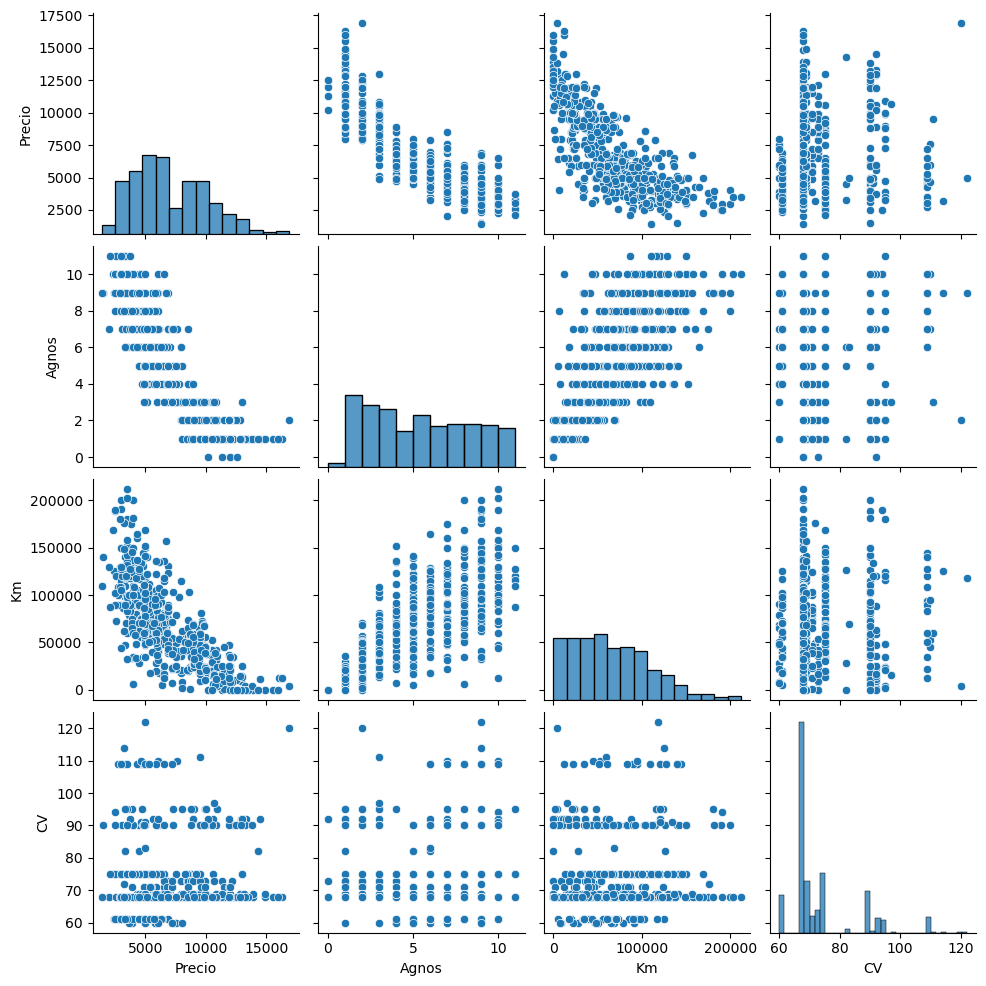

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

plt.close('all')

# Leer los ficheros de datos y pasarlos a matrices de numpy
coches_train = pd.read_csv(Path+'CochesTrain.csv', sep = ";")
x1_train = coches_train["Agnos"].to_numpy().reshape(-1, 1)
x2_train = coches_train["Km"].to_numpy().reshape(-1, 1)
x3_train = coches_train["CV"].to_numpy().reshape(-1, 1)
y_train  = coches_train["Precio"].to_numpy()

coches_test  = pd.read_csv(Path+'CochesTest.csv',  sep = ";")
x1_test = coches_test["Agnos"].to_numpy().reshape(-1, 1)
x2_test = coches_test["Km"].to_numpy().reshape(-1, 1)
x3_test = coches_test["CV"].to_numpy().reshape(-1, 1)
y_test  = coches_test["Precio"].to_numpy()

# Mostrar los datos de entrenamiento
seaborn.pairplot(coches_train)
plt.show()

Los datos parecen seguir una relación de grado 2 sin muchos espurios, por lo que se espera que un modelo polinomial de grado 2 sea suficiente para modelar los datos.

## Funciones de utilidad

In [3]:
def draw_residuals(y_train, y_pred_train, y_test, y_pred, xlabel, ylabel, title = 'Residuos'):
    """
    Función que dibuja los residuos de los datos de entrenamiento y test
    Parámetros:
    y_train: array con los valores reales de los datos de entrenamiento
    y_pred_train: array con los valores predichos de los datos de entrenamiento
    y_test: array con los valores reales de los datos de test
    y_pred: array con los valores predichos de los datos de test
    title: título del gráfico
    xlabel: etiqueta del eje x
    ylabel: etiqueta del eje y

    Devuelve:
    Gráfico con los residuos de los datos de entrenamiento y test
    """
    plt.figure()
    # Pintamos los residuos de los datos de train
    plt.scatter(y_train, y_train - y_pred_train, c = 'blue', marker = '.', label = 'train')
    # Pintamos los residuos de los datos de test
    plt.scatter(y_test, y_test - y_pred, c = 'red', marker = 'x', label = 'test')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()

In [4]:
def draw_predictions(y_train, y_pred_train, y_test, y_pred, title = 'Residuos', xlabel = 'Precio Real', ylabel = 'Precio Predicho'):
    """
    Función que dibuja las predicciones de los datos de entrenamiento y test
    Parámetros:
    y_train: array con los valores reales de los datos de entrenamiento
    y_pred_train: array con los valores predichos de los datos de entrenamiento
    y_test: array con los valores reales de los datos de test
    y_pred: array con los valores predichos de los datos de test
    title: título del gráfico
    xlabel: etiqueta del eje x
    ylabel: etiqueta del eje y

    Devuelve:
    Gráfico con las predicciones de los datos de entrenamiento y test
    """
    plt.figure()
    # Pintamos las predicciones de los datos de train
    plt.scatter(y_train, y_pred_train, c = 'blue', marker = '.', label = 'train')
    # Pintamos las predicciones de los datos de test
    plt.scatter(y_test, y_pred, c = 'red', marker = 'x', label = 'test')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show() 

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

results = pd.DataFrame() # Variable global para guardar la tabla de resultados
## Función para añadir las métricas de un modelo a la tabla de resultados
def addMetricsToResults(label, y_train, y_train_pred, y_test, y_test_pred, results_var=None, displayMetric=True):
    """
    Función que añade las métricas de un modelo a la tabla de resultados global o 
    a la tabla que se le pase como argumento.

    Parámetros:
    - label: Etiqueta para identificar el modelo.
    - y_train: Valores reales del conjunto de entrenamiento.
    - y_train_pred: Valores predichos por el modelo para el conjunto de entrenamiento.
    - y_test: Valores reales del conjunto de prueba.
    - y_test_pred: Valores predichos por el modelo para el conjunto de prueba.
    - results_var: Tabla de resultados a la que añadir las métricas. Si no se pasa, se añaden a la tabla global.
    - displayMetric: Si es True, muestra las métricas por pantalla.

    Retorna:
    No retorna ningún valor, pero agrega una fila con las métricas calculadas a la tabla de resultados global.
    """
    global results
    
    next_res = pd.DataFrame(
        {"Label": label,
        "R2_train"  :  [r2_score(y_train, y_train_pred)],
        "RMSE_train":  [mean_squared_error(y_train, y_train_pred, squared=False)],
        "MRE_train" :  [mean_absolute_percentage_error(y_train, y_train_pred)],
        "MAE_train" :  [mean_absolute_error(y_train, y_train_pred)],

        "R2_test"  :  [r2_score(y_test, y_test_pred)],
        "RMSE_test":  [mean_squared_error(y_test, y_test_pred, squared=False)],
        "MRE_test" :  [mean_absolute_percentage_error(y_test, y_test_pred)],
        "MAE_test" :  [mean_absolute_error(y_test, y_test_pred)],
        })
    
    if displayMetric:
        display(next_res)

    if results_var is not None:
        # Añadir la fila a la tabla de resultados, concat() devuelve una nueva tabla con la fila añadida
        results_var = pd.concat([results_var, next_res], ignore_index=True) #ignore_index=True para que el índice de las filas sea consecutivo y no repita valores, si es False (por defecto) el índice de las filas es el de los dataframes que se concatenanç
        return results_var
    else:
        results = pd.concat([results, next_res], ignore_index=True)

In [6]:
import sklearn
print(sklearn.__version__)

1.3.0


----
## 1. Regresión Lineal

Como punto de partida para la práctica, vamos a implementar un modelo de regresión lineal simple.

### 1.1. Regresión lineal simple

Función de predicción tras el entrenamiento:
f(x) = (w_0, w_1 ... w_D) * (1, x_1, ... x_D)
f(x) = ( 9244.826300856275 [-7.31485554e+02 -1.67617525e-02  3.43796857e+01] ) * (1, x_1, x_2, x_3)


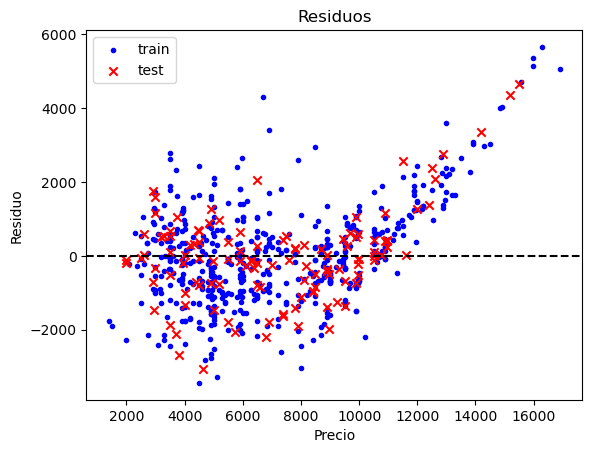

,Label,R2_train,RMSE_train,MRE_train,MAE_train,R2_test,RMSE_test,MRE_test,MAE_test
0,LinearRegression(),0.814531,1315.230245,0.166736,996.735227,0.840414,1232.97811,0.140014,870.385627


In [7]:
from sklearn.linear_model import LinearRegression

x_train = np.concatenate((x1_train, x2_train, x3_train), axis = 1)
x_test = np.concatenate((x1_test, x2_test, x3_test), axis = 1)

# Entrenar el modelo con función de coste mínimos cuadrados (por defecto )
linear_regr = LinearRegression() 
linear_regr.fit(x_train, y_train)

# Predecir los valores de validación y de test
y_pred_train = linear_regr.predict(x_train)
y_pred = linear_regr.predict(x_test)

# Mostrar los coeficientes
print("Función de predicción tras el entrenamiento:")
print("f(x) = (w_0, w_1 ... w_D) * (1, x_1, ... x_D)")
print("f(x) = (", linear_regr.intercept_, linear_regr.coef_, ") * (1, x_1, x_2, x_3)")


draw_residuals(y_train, y_pred_train, y_test, y_pred, 'Precio', 'Residuo')
addMetricsToResults("LinearRegression()", y_train, y_pred_train, y_test, y_pred)

### 1.3. Conclusiones

In [8]:
results

,Label,R2_train,RMSE_train,MRE_train,MAE_train,R2_test,RMSE_test,MRE_test,MAE_test
0,LinearRegression(),0.814531,1315.230245,0.166736,996.735227,0.840414,1232.97811,0.140014,870.385627


Los resultado son sorprendentemente buenos, con un error relativo medio de en torno al 14% y un r2 de 0.84 en test. Por lo que podemos deducir que la relación entre las variables de entrada (años, kilómetros y cv) y la variable de salida (precio) es bastante lineal.

----
## 2. Selección del grado del polinomio


Buscaremos el mejor modelo polinómico con grado entre 1 y 10 por validación cruzada con k-fold. Dibujaremos las curvas de evolución de los errores RMSE de entrenamiento y validación en función del grado del polinomio.

### 2.1. Selección del mejor modelo polinómico

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#from sklearn.model_selection import cross_val_score
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

# Uso de cross_validate porque cross_val_score no permite calcular varias métricas a la vez
# cross_validate devuelve un diccionario con las métricas calculadas y más información
from sklearn.model_selection import cross_validate 
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

train_rmse = []
val_rmse = []
grados = range(1, 11)
for grado in grados:
    print("Entrenando modelo de grado", grado)
    print("--------------------------------------------------")

    # Creamos el modelo de regresión polinómica
    model = make_pipeline(StandardScaler(), PolynomialFeatures(degree=grado), LinearRegression())

    # Realizamos la validación cruzada y obtenemos las métricas de cada partición
    scores = cross_validate(model, x_train, y_train, cv=10, return_train_score=True, scoring='neg_root_mean_squared_error')
    # scores es un dicciónario con 'fit_time', 'score_time', 'test_score' y 'train_score'
    print("RMSE de entrenamiento:", -np.mean(scores['train_score']))
    print("RMSE de validación:", -np.mean(scores['test_score']))

    # Pasamos el error a positivo y lo guardamos
    train_rmse.append(-np.mean(scores['train_score']))
    val_rmse.append(-np.mean(scores['test_score']))

Entrenando modelo de grado 1
--------------------------------------------------
RMSE de entrenamiento: 1314.4804031362917
RMSE de validación: 1311.796636918516
Entrenando modelo de grado 2
--------------------------------------------------


RMSE de entrenamiento: 1163.1359985727468
RMSE de validación: 1182.9624819896417
Entrenando modelo de grado 3
--------------------------------------------------
RMSE de entrenamiento: 1127.0629403392898
RMSE de validación: 1180.3043389247257
Entrenando modelo de grado 4
--------------------------------------------------
RMSE de entrenamiento: 1096.4626266591144
RMSE de validación: 1306.4223233632863
Entrenando modelo de grado 5
--------------------------------------------------
RMSE de entrenamiento: 1030.9250314973474
RMSE de validación: 2234.7436497591734
Entrenando modelo de grado 6
--------------------------------------------------
RMSE de entrenamiento: 968.6869672835064
RMSE de validación: 4602.858236806153
Entrenando modelo de grado 7
--------------------------------------------------
RMSE de entrenamiento: 927.9126520794413
RMSE de validación: 20829.07679142593
Entrenando modelo de grado 8
--------------------------------------------------
RMSE de entrenamiento: 872.08337916389

[1314.4804031362917, 1163.1359985727468, 1127.0629403392898, 1096.4626266591144, 1030.9250314973474, 968.6869672835064, 927.9126520794413, 872.0833791638921, 830.4730721217451, 730.9532747277129]
[1311.796636918516, 1182.9624819896417, 1180.3043389247257, 1306.4223233632863, 2234.7436497591734, 4602.858236806153, 20829.07679142593, 100456.49185801086, 4797105.929888374, 578181418.077252]


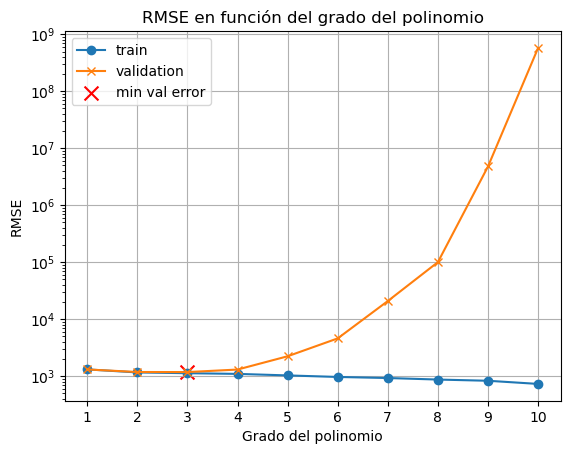

In [10]:
print(train_rmse)
print(val_rmse)
# Mostramos la evolución el RMSE en función del grado del polinomio
plt.figure()
plt.plot(grados, train_rmse, label="train", marker='o')
plt.plot(grados, val_rmse, label="validation", marker='x')
plt.xlabel("Grado del polinomio")
# Pintamos el punto mínimo en el eje y, el de menor error de validación
plt.scatter(grados[np.argmin(val_rmse)], min(val_rmse), c='red', marker='x', label='min val error', s=100)
plt.xticks(grados) # Para que muestre todos los grados
plt.ylabel("RMSE")
plt.title("RMSE en función del grado del polinomio")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

Como podemos observar en la gráfica, el error de entrenamiento disminuye a medida que aumentamos el grado del polinomio. Sin embargo, el error de validación disminuye hasta el grado 3 y a partir de ahí empieza a aumentar. Esto indica que el modelo empieza a sobreajustar a partir del grado 3.

Como el error de validación entre el grado 2 y 3 varía en 2 unidades, se debería tender a seleccionar como mejor modelo el de grado 2 ya que es más sencillo y por tanto menos propenso a sobreajustar.
Por aportar más información antes de llegar a una conclusion final entrenaremos ambos modelos y compararemos los resultados.

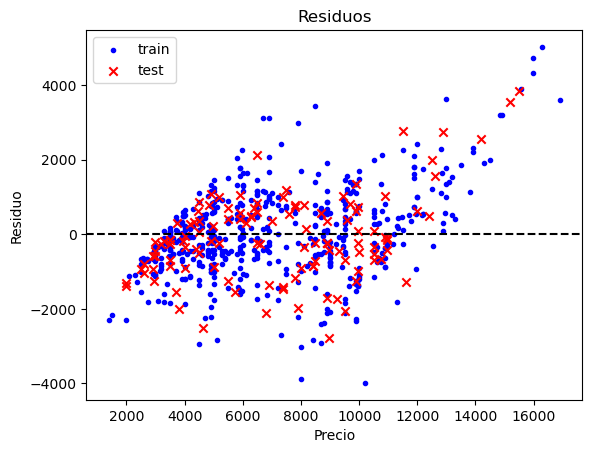

,Label,R2_train,RMSE_train,MRE_train,MAE_train,R2_test,RMSE_test,MRE_test,MAE_test
0,PolynomialRegressionG2,0.854555,1164.704012,0.140712,875.118782,0.865421,1132.262399,0.13841,861.761376


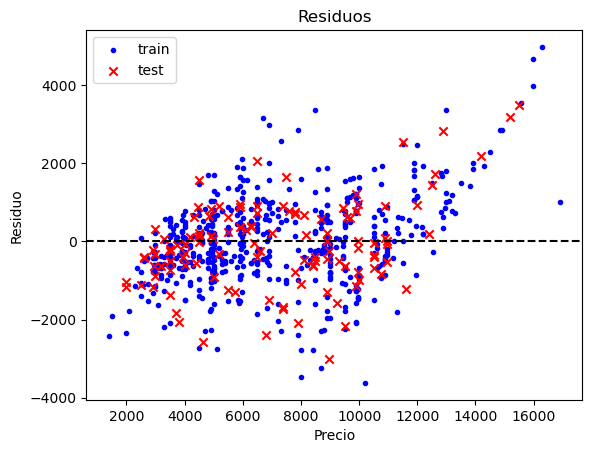

,Label,R2_train,RMSE_train,MRE_train,MAE_train,R2_test,RMSE_test,MRE_test,MAE_test
0,PolynomialRegressionG3,0.863136,1129.826167,0.139574,860.701344,0.869789,1113.736369,0.133903,837.468604


In [11]:

model = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), LinearRegression())

model.fit(x_train, y_train)

# Predecir los valores de validación y de test
y_pred_train = model.predict(x_train)
y_pred = model.predict(x_test)

draw_residuals(y_train, y_pred_train, y_test, y_pred, 'Precio', 'Residuo')
addMetricsToResults("PolynomialRegressionG2", y_train, y_pred_train, y_test, y_pred)


model = make_pipeline(PolynomialFeatures(degree=3), StandardScaler(), LinearRegression())

model.fit(x_train, y_train)

# Predecir los valores de validación y de test
y_pred_train = model.predict(x_train)
y_pred = model.predict(x_test)

draw_residuals(y_train, y_pred_train, y_test, y_pred, 'Precio', 'Residuo')
addMetricsToResults("PolynomialRegressionG3", y_train, y_pred_train, y_test, y_pred)

### 2.2. Conclusiones

In [12]:
results

,Label,R2_train,RMSE_train,MRE_train,MAE_train,R2_test,RMSE_test,MRE_test,MAE_test
0,LinearRegression(),0.814531,1315.230245,0.166736,996.735227,0.840414,1232.978110,0.140014,870.385627
1,PolynomialRegressionG2,0.854555,1164.704012,0.140712,875.118782,0.865421,1132.262399,0.138410,861.761376
2,PolynomialRegressionG3,0.863136,1129.826167,0.139574,860.701344,0.869789,1113.736369,0.133903,837.468604


Observamos que el error cuadrático medio de validación crece de forma exponencial a partir del grado 3. Esto se debe a que el modelo se está sobreajustando a los datos de entrenamiento, cuanto más aumenta el grado más se está sobreajustando, de forma que adapta su función de predicción demasiado a los datos de entrenamiento y no generaliza bien con los datos de test.

El dilema está entre la elección del mejor grado para el polinomio. El de grado 2 y grado 3 tienen un error en validación que difiere en 2 unidades por lo que ante tal situación se debería tender a seleccionar el modelo más sencillo, es decir, el de grado 2 para evitar el sobreajuste. Tras analizar ambos modelos con los resultados de test se observa lo mismo, las métricas para entrenamiento son ligeramente mejores para el modelo de grado 3 y prácticamente iguales para test (solo con una diferencia en el tercer decimal de r2) y MRE.

Por lo tanto, ante el comportamiento practicamente igual en validación y test de ambos modelos se debería elegir el modelo más sencillo, es decir, el de grado 2.

Es notable que cualquiera de los dos modelos polinómicos superan en todas las métricas al modelo de regresión lineal simple. Esto indica que la relación entre las variables de entrada(agnos, kilómetros y cv) y la variable de salida (precio) no es exactamente lineal, sino que es polinómica.

## 3. Regresión polinómica regularizada

Fijaremos el grado del polinomio a 10 y aplicaremos regresión regularizada buscando el mejor valor del parámetro de regularización por validación cruzada con k-fold.

### 3.1. Regresión polinómica regularizada con regularización L2 - Ridge

In [13]:
#from sklearn.linear_model import RidgeCV
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html
# RidgeCV es una versión de Ridge que ya tiene validación cruzada para seleccionar el parámetro de regularización
# Pero no podía sacar las métricas de forma fácil, así que he usado Ridge con cross_validate

from sklearn.linear_model import Ridge
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html


# Valor que toma el parámetro de regularización, cuanto más alto más regularización (penalización)
lambda_values = np.logspace(-10, 10, 30) # Intervalo ajustado tras varias pruebas
degree = 10
kfolds = 10

train_rmse = []
val_rmse = []

print("lambda_values:", lambda_values)

for lambda_val in lambda_values:

    # Creamos el modelo de regresión polinómica
    #* Importante: Primero se hace la expansión polinómica y después se normalizan los datos
    #* para que la regularización actúe sobre los coeficientes de la expansión polinómica
    #* Si se escalan los datos antes de la expansión polinómica, la regularización actuará sobre
    #* los coeficientes de los polinomios, pero no sobre los coeficientes de los términos cruzados
    model = make_pipeline(PolynomialFeatures(degree=degree),StandardScaler(), Ridge(alpha=lambda_val))

    # Realizamos la validación cruzada y obtenemos las métricas de cada partición
    scores = cross_validate(model, x_train, y_train, cv=kfolds, return_train_score=True, scoring='neg_root_mean_squared_error')

    # Pasamos el error a positivo y lo guardamos
    train_rmse.append(-np.mean(scores['train_score']))
    val_rmse.append(-np.mean(scores['test_score']))

print(train_rmse)
print(val_rmse)

lambda_values: [1.00000000e-10 4.89390092e-10 2.39502662e-09 1.17210230e-08
 5.73615251e-08 2.80721620e-07 1.37382380e-06 6.72335754e-06
 3.29034456e-05 1.61026203e-04 7.88046282e-04 3.85662042e-03
 1.88739182e-02 9.23670857e-02 4.52035366e-01 2.21221629e+00
 1.08263673e+01 5.29831691e+01 2.59294380e+02 1.26896100e+03
 6.21016942e+03 3.03919538e+04 1.48735211e+05 7.27895384e+05
 3.56224789e+06 1.74332882e+07 8.53167852e+07 4.17531894e+08
 2.04335972e+09 1.00000000e+10]


[859.2328672386936, 872.1569493054756, 884.1400062683036, 897.9371103173778, 913.426665473166, 929.5156968372337, 946.008916667138, 962.5245718060653, 978.4637982651127, 997.1459657083724, 1019.1936442173779, 1037.9012315529642, 1057.179186202804, 1078.6621781393617, 1100.4251735507064, 1124.991390274536, 1152.7722955570775, 1199.8517834943807, 1329.7480650755774, 1603.314021129257, 2070.3984479847322, 2479.5253345012015, 2768.638832877334, 2965.0326758109177, 3033.138846468288, 3049.1095052615938, 3052.4715784685563, 3053.162817661034, 3053.304241111787, 3053.3331464690636]
[30034.422265922487, 24227.90049735606, 15558.110671769202, 10109.244429523074, 6253.755561664975, 4395.68422253009, 3804.8623547122056, 3486.5519076505866, 3223.6615030748226, 2846.1934838204857, 2651.8350756747705, 2075.238012885688, 1541.1267364213782, 1279.2782465441728, 1210.785724169366, 1201.6646131089249, 1203.1198247480443, 1226.5221470216597, 1346.4874008430793, 1603.7124328468092, 2060.347375825659, 2469

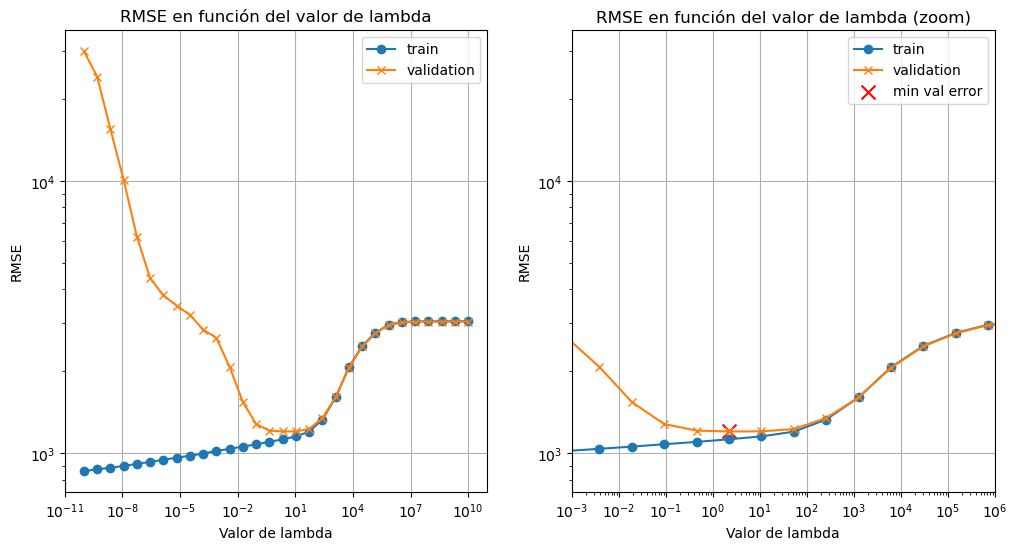

Valor de lambda que minimiza el error de validación: 2.21221629107045
Error de validación mínimo: 1201.6646131089249


In [14]:
# Mostramos la evolución el RMSE en función del valor de lambda
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(lambda_values, train_rmse, label="train", marker='o')
ax[0].plot(lambda_values, val_rmse, label="validation", marker='x')
ax[0].set_xlabel("Valor de lambda")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_ylabel("RMSE")
ax[0].set_title("RMSE en función del valor de lambda")
ax[0].legend()
ax[0].grid()

# Ahora mostraremos un zoom en la zona donde se encuentra el mínimo
ax[1].plot(lambda_values, train_rmse, label="train", marker='o')
ax[1].plot(lambda_values, val_rmse, label="validation", marker='x')
ax[1].scatter(lambda_values[np.argmin(val_rmse)], min(val_rmse), c='red', marker='x', label='min val error', s=100)
ax[1].set_xlabel("Valor de lambda")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_ylabel("RMSE")
ax[1].set_title("RMSE en función del valor de lambda (zoom)")
ax[1].legend()
ax[1].grid()
ax[1].set_xlim(1e-3, 1e6)
plt.show()

print("Valor de lambda que minimiza el error de validación:", lambda_values[np.argmin(val_rmse)])
print("Error de validación mínimo:", min(val_rmse))

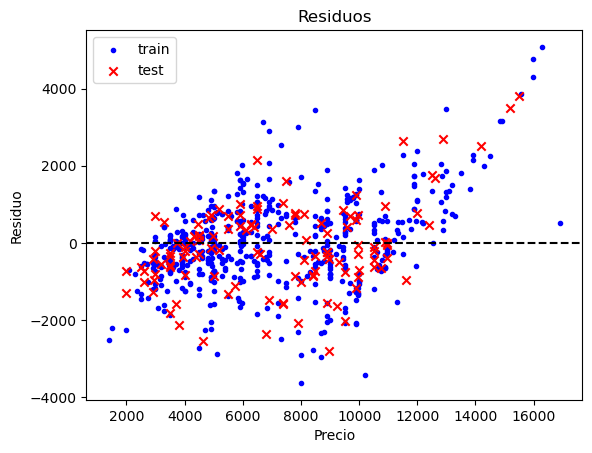

,Label,R2_train,RMSE_train,MRE_train,MAE_train,R2_test,RMSE_test,MRE_test,MAE_test
0,RidgeRegression,0.864016,1126.187298,0.135634,845.521729,0.86746,1123.650091,0.135471,845.154318


f(x) = (w_0, w_1 ... w_D) * (1, x_1, ... x_D)
f(x) = ( 7052.1412844036695 [ 0.00000000e+00 -1.57508720e+03 -1.51661641e+03  9.01332690e+02
 -7.55775933e+02  2.26196092e+02 -7.56324914e+02  3.18774007e+02
 -6.51405947e+02  2.56616536e+02  1.99796892e+01  3.66944263e+02
 -4.18411103e+02  7.05086266e+01  3.44804343e+02 -3.17423758e+02
  8.11548710e+01  3.64021169e+02 -6.22422291e+01 -1.46389062e+02
  2.42149772e+02  3.15418297e+02  1.51814328e+02  1.44410882e+01
  3.48898243e+02 -2.66729519e+02 -2.79489358e+01  6.31031171e+00
  2.85688265e+02 -1.39580822e+02  5.34985467e+01 -2.43526116e+01
  3.05341253e+02  2.22646943e+02 -3.47485376e+02  1.66993812e+02
  1.72538290e+02  2.94691211e+02 -2.00433493e+01  2.80872048e+02
  1.48368642e+02 -3.24005555e+01 -4.24591770e+01  2.28125481e+02
 -2.15070776e+02  5.46974351e+01 -1.24413698e+02 -8.52996076e+01
  1.44154305e+02 -6.79151078e+01  1.04722794e+02 -7.41092916e+01
 -1.20621428e+02  1.96227278e+02  2.84483543e+02 -3.89084877e+02
  7.76513947e+00

In [15]:
# Entrenamos un modelo con el valor de lambda que minimiza el error de validación
model = make_pipeline(PolynomialFeatures(degree=degree), StandardScaler(), Ridge(alpha=lambda_values[np.argmin(val_rmse)]))
model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
y_pred = model.predict(x_test)

draw_residuals(y_train, y_pred_train, y_test, y_pred, 'Precio', 'Residuo')
addMetricsToResults("RidgeRegression", y_train, y_pred_train, y_test, y_pred)


# Mostramos los pesos de los coeficientes
print("f(x) = (w_0, w_1 ... w_D) * (1, x_1, ... x_D)")
print("f(x) = (", model.named_steps['ridge'].intercept_, model.named_steps['ridge'].coef_, ") * (1, x_1, x_2, x_3)")


#### 3.3. Análisis de los resultados

In [16]:
results

,Label,R2_train,RMSE_train,MRE_train,MAE_train,R2_test,RMSE_test,MRE_test,MAE_test
0,LinearRegression(),0.814531,1315.230245,0.166736,996.735227,0.840414,1232.978110,0.140014,870.385627
1,PolynomialRegressionG2,0.854555,1164.704012,0.140712,875.118782,0.865421,1132.262399,0.138410,861.761376
2,PolynomialRegressionG3,0.863136,1129.826167,0.139574,860.701344,0.869789,1113.736369,0.133903,837.468604
3,RidgeRegression,0.864016,1126.187298,0.135634,845.521729,0.867460,1123.650091,0.135471,845.154318


Mediante la regularización L2 hemos conseguido reducir el sobreajuste del modelo polinómico de grado 10. El valor de lambda de aproximadamente 2 consigue reducir el error de validación al mínimo consiguiendo que este modelo se comporte practicamente igual que los modelos de grado 2 y 3. 

Esto se debe a que en la regularización ha dado lugar a que coeficientes más grandes (10 veces más) sean los de grado 2 y 3 y por tanto el modelo se comporte de forma similar a estos.

### 3.3. Regresión polinómica regularizada con regularización L1 - Lasso

La diferencia entre la regularización L1 y L2 es que la L1 tiende a hacer que los coeficientes de las variables de entrada sean 0, es decir, tiende a seleccionar las variables más importantes. Por tanto, la regularización L1 es útil para seleccionar variables. En cuanto a la regularización L2 tiende a hacer que los coeficientes de las variables de entrada sean pequeños pero no llega a hacerlos 0 como ya hemos visto antes.

In [17]:
from sklearn.linear_model import Lasso
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

# Valor que toma el parámetro de regularización, cuanto más alto más regularización (penalización)
lambda_values = np.logspace(-5, 6, 15) # Intervalo ajustado tras varias pruebas
degree = 10
kfolds = 10

train_rmse = []
val_rmse = []

print("lambda_values:", lambda_values)

for lambda_val in lambda_values:
    # lasso necesita max_iter alto para converger con algunos valores de lambda
    # Esto se debe a que Lasso es más exigente que Ridge con la convergencia

    # Creamos el modelo de regresión polinómica
    model = make_pipeline(PolynomialFeatures(degree=degree), StandardScaler(), Lasso(alpha=lambda_val, max_iter=10000))

    # Realizamos la validación cruzada y obtenemos las métricas de cada partición
    scores = cross_validate(model, x_train, y_train, cv=kfolds, return_train_score=True, scoring='neg_root_mean_squared_error')

    # Pasamos el error a positivo y lo guardamos
    train_rmse.append(-np.mean(scores['train_score']))
    val_rmse.append(-np.mean(scores['test_score']))

print(train_rmse)
print(val_rmse)

lambda_values: [1.00000000e-05 6.10540230e-05 3.72759372e-04 2.27584593e-03
 1.38949549e-02 8.48342898e-02 5.17947468e-01 3.16227766e+00
 1.93069773e+01 1.17876863e+02 7.19685673e+02 4.39397056e+03
 2.68269580e+04 1.63789371e+05 1.00000000e+06]


c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.886e+08, tolerance: 4.704e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.854e+08, tolerance: 4.577e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[1073.2008941105844, 1073.2008554070362, 1073.2006436379143, 1073.2001075160392, 1073.2281515133084, 1074.7619852299408, 1093.2453269680962, 1140.1106772680866, 1165.4534404483638, 1269.7128186944617, 1573.6650245656635, 3053.3405701166753, 3053.3405701166753, 3053.3405701166753, 3053.3405701166753]
[1478.0148841856599, 1477.9066728469309, 1477.2464962256136, 1473.2307857042128, 1449.2089310307015, 1321.268341361175, 1184.186703593838, 1184.50925075222, 1188.728790442771, 1270.3529004627517, 1558.3688168808328, 3044.3782641874873, 3044.3782641874873, 3044.3782641874873, 3044.3782641874873]


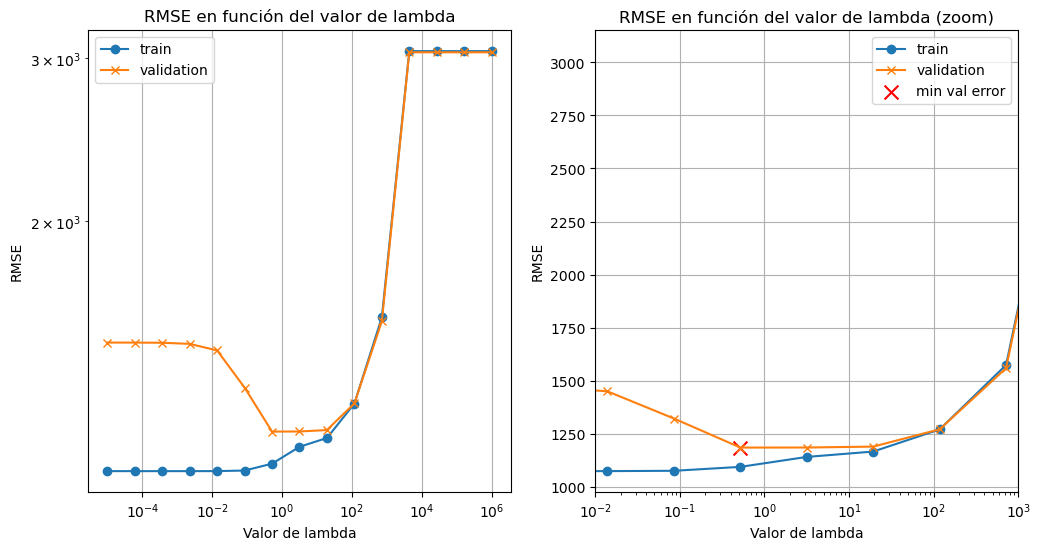

Valor de lambda que minimiza el error de validación: 0.5179474679231213
Error de validación mínimo: 1184.186703593838


In [18]:
# Mostramos la evolución el RMSE en función del valor de lambda
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(lambda_values, train_rmse, label="train", marker='o')
ax[0].plot(lambda_values, val_rmse, label="validation", marker='x')
ax[0].set_xlabel("Valor de lambda")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_ylabel("RMSE")
ax[0].set_title("RMSE en función del valor de lambda")
ax[0].legend()
ax[0].grid()

# Ahora mostraremos un zoom en la zona donde se encuentra el mínimo
ax[1].plot(lambda_values, train_rmse, label="train", marker='o')
ax[1].plot(lambda_values, val_rmse, label="validation", marker='x')
ax[1].scatter(lambda_values[np.argmin(val_rmse)], min(val_rmse), c='red', marker='x', label='min val error', s=100)
ax[1].set_xlabel("Valor de lambda")
ax[1].set_xscale("log")
ax[1].set_ylabel("RMSE")
ax[1].set_title("RMSE en función del valor de lambda (zoom)")
ax[1].legend()
ax[1].grid()
ax[1].set_xlim(1e-2, 1e3)
plt.show()


print("Valor de lambda que minimiza el error de validación:", lambda_values[np.argmin(val_rmse)])
print("Error de validación mínimo:", min(val_rmse))

c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e+07, tolerance: 5.083e+05
  model = cd_fast.enet_coordinate_descent(


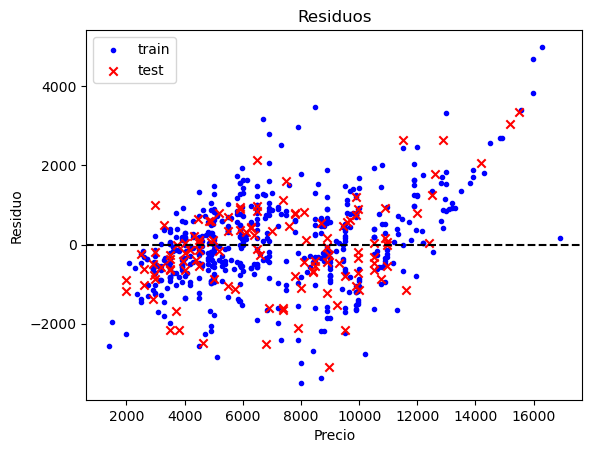

,Label,R2_train,RMSE_train,MRE_train,MAE_train,R2_test,RMSE_test,MRE_test,MAE_test
0,LassoRegression,0.870973,1097.001209,0.133534,828.055893,0.872686,1101.274447,0.13442,830.76246


f(x) = (w_0, w_1 ... w_D) * (1, x_1, ... x_D)
f(x) = ( 7052.141284403671 [ 0.00000000e+00 -1.31619750e+03 -4.62205637e+03  1.90951842e+03
 -2.76221077e+03  3.95563990e+03 -0.00000000e+00  3.10830243e+03
  0.00000000e+00 -0.00000000e+00  3.76681445e+02  0.00000000e+00
 -1.94728657e+03 -1.90687192e+03  5.96677309e+02 -0.00000000e+00
 -0.00000000e+00  1.39495025e+03  0.00000000e+00 -1.39796440e+03
  2.47466891e+03  0.00000000e+00  1.29345609e+02 -3.25302223e+02
  0.00000000e+00 -7.88938384e+02 -0.00000000e+00 -1.02244693e+03
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -7.59520929e+02
  0.00000000e+00  8.78395256e+02 -1.03135389e+03  0.00000000e+00
 -0.00000000e+00  2.78249739e+03 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -1.17886697e+03  0.00000000e+00 -0.00000000e+00 -5.06375386e+02
 -0.00000000e+00 -3.64717535e-01  0.00000000e+00 -0.00000000e+00
 -1.42268146e+03  0.00000000e+00  1.38862797e+03 -0.00000000e+00
 -0.00000000e+00 

In [19]:
# Entrenamos un modelo con el valor de lambda que minimiza el error de validación
model = make_pipeline(PolynomialFeatures(degree=degree), StandardScaler(), Lasso(alpha=lambda_values[np.argmin(val_rmse)], max_iter=10000))
model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
y_pred = model.predict(x_test)

draw_residuals(y_train, y_pred_train, y_test, y_pred, 'Precio', 'Residuo')
addMetricsToResults("LassoRegression", y_train, y_pred_train, y_test, y_pred)


# Mostramos los pesos de los coeficientes
print("f(x) = (w_0, w_1 ... w_D) * (1, x_1, ... x_D)")
print("f(x) = (", model.named_steps['lasso'].intercept_, model.named_steps['lasso'].coef_, ") * (1, x_1, x_2, x_3)")


#### 3.4. Análisis de los resultados

Ocurre igual que con la regularización L2, predice siempre el valor medio de la variable de salida. Ya que como podemos observar, ha puesto muchos coeficientes a 0 y los que no, son muy pequeños en comparación con los correspondientes a los términos de grado 2 y 3.

## 4. Regresión con redes neuronales sin regularizar

Probaremos a continuación dos redes, una sin capa oculta y otra con una capa de 100 neuronas.

### 4.1. Red neuronal sin capa oculta

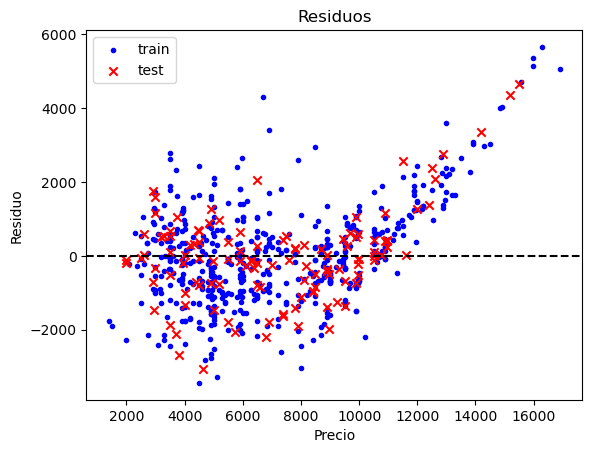

,Label,R2_train,RMSE_train,MRE_train,MAE_train,R2_test,RMSE_test,MRE_test,MAE_test
0,MLPRegressor0,0.814531,1315.230245,0.166736,996.735443,0.840414,1232.977957,0.140014,870.385435


In [20]:
from sklearn.neural_network import MLPRegressor
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

# solver es el algoritmo de optimización, en este caso lbfgs que es el más adecuado para datasets pequeños
# alpha es el término de regularización, lo ponemos a 0 para que no haya regularización porque ya se aplica en el StandardScaler
mlp = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(), solver='lbfgs', alpha=0, verbose=True, max_iter=10000))
mlp.fit(x_train, y_train)

y_pred_train = mlp.predict(x_train)
y_pred = mlp.predict(x_test)

draw_residuals(y_train, y_pred_train, y_test, y_pred, 'Precio', 'Residuo')
addMetricsToResults("MLPRegressor0", y_train, y_pred_train, y_test, y_pred)

In [21]:
results

,Label,R2_train,RMSE_train,MRE_train,MAE_train,R2_test,RMSE_test,MRE_test,MAE_test
0,LinearRegression(),0.814531,1315.230245,0.166736,996.735227,0.840414,1232.978110,0.140014,870.385627
1,PolynomialRegressionG2,0.854555,1164.704012,0.140712,875.118782,0.865421,1132.262399,0.138410,861.761376
2,PolynomialRegressionG3,0.863136,1129.826167,0.139574,860.701344,0.869789,1113.736369,0.133903,837.468604
3,RidgeRegression,0.864016,1126.187298,0.135634,845.521729,0.867460,1123.650091,0.135471,845.154318
4,LassoRegression,0.870973,1097.001209,0.133534,828.055893,0.872686,1101.274447,0.134420,830.762460
5,MLPRegressor0,0.814531,1315.230245,0.166736,996.735443,0.840414,1232.977957,0.140014,870.385435


### 4.2. Análisis de los resultados

Como podemos observar al no tener capa oculta el modelo se comporta igual que el regresor lineal ya que el optimizador lbfgs resuelve la ecuación normal y encuentra la solución óptima para la función de coste. Es decir, ambos modelos consiguen la misma función de predicción porque ambos modelos resuelven la ecuación normal para obtener la solución óptima.

### 4.3. Red neuronal con capa oculta

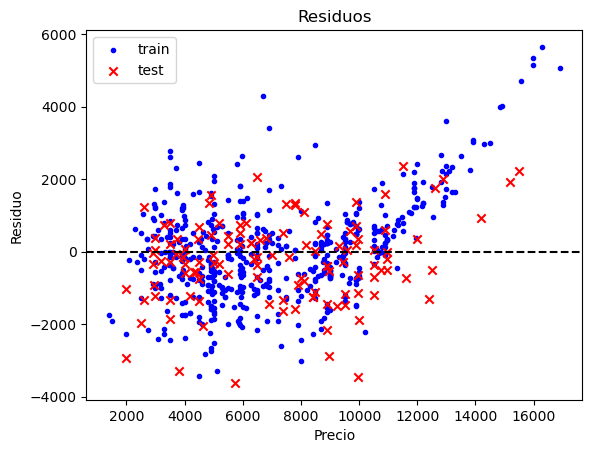

,Label,R2_train,RMSE_train,MRE_train,MAE_train,R2_test,RMSE_test,MRE_test,MAE_test
0,MLPRegressor100,0.814531,1315.230245,0.166736,996.735443,0.853104,1182.939572,0.156434,901.207507


In [22]:
mlp2 = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(100,), solver = 'lbfgs', alpha=0, verbose=True, max_iter=10000))
mlp2.fit(x_train, y_train)

y_train_pred = mlp2.predict(x_train)
y_pred = mlp2.predict(x_test)


draw_residuals(y_train, y_pred_train, y_test, y_pred, 'Precio', 'Residuo')
addMetricsToResults("MLPRegressor100", y_train, y_pred_train, y_test, y_pred)



### 4.4 Análisis de los resultados

In [23]:
results

,Label,R2_train,RMSE_train,MRE_train,MAE_train,R2_test,RMSE_test,MRE_test,MAE_test
0,LinearRegression(),0.814531,1315.230245,0.166736,996.735227,0.840414,1232.978110,0.140014,870.385627
1,PolynomialRegressionG2,0.854555,1164.704012,0.140712,875.118782,0.865421,1132.262399,0.138410,861.761376
2,PolynomialRegressionG3,0.863136,1129.826167,0.139574,860.701344,0.869789,1113.736369,0.133903,837.468604
3,RidgeRegression,0.864016,1126.187298,0.135634,845.521729,0.867460,1123.650091,0.135471,845.154318
4,LassoRegression,0.870973,1097.001209,0.133534,828.055893,0.872686,1101.274447,0.134420,830.762460
5,MLPRegressor0,0.814531,1315.230245,0.166736,996.735443,0.840414,1232.977957,0.140014,870.385435
6,MLPRegressor100,0.814531,1315.230245,0.166736,996.735443,0.853104,1182.939572,0.156434,901.207507


Los resultados en train de las dos redes neuronales (sin capa oculta y con 100 neuronas) son exactamente iguales. Esto se debe a que el optimizador lbfgs resuelve la ecuación normal y encuentra la solución óptima para la función de coste. Es decir, ambos modelos consiguen la misma función de predicción porque ambos modelos resuelven la ecuación normal para obtener la solución óptima.

Sin embargo, los resultados de test son curiosos. El RMSE de test de la red con capa oculta es menor que el de la red sin capa oculta y el r2 mayor, por lo que la red con capa oculta parecería mejor. No obstante, el error relativo medio es mayor en la red con capa oculta que en la red sin capa oculta. Esto puede deberse a que la red con capa oculta tiene menor error en los coches más caros y mayor en los coches más baratos, por lo que el error relativo medio es mayor.

### 5. Regresión con red neuronal con capa oculta regularizada

Buscaremos ahora el mejor valor para el parámetro de regularización por validación cruzada con k-fold.

### 5.1. Red neuronal con capa oculta regularizada

In [24]:
lambda_values = np.logspace(-3, 7, 20) # Intervalo ajustado tras varias pruebas
kfolds = 10

train_rmse = []
val_rmse = []

print("lambda_values:", lambda_values)

for lambda_val in lambda_values:
    model = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(100,), solver='lbfgs', alpha=lambda_val, verbose=True, max_iter=1000))

    scores = cross_validate(model, x_train, y_train, cv=kfolds, return_train_score=True, scoring='neg_root_mean_squared_error', n_jobs=5)

    train_rmse.append(-np.mean(scores['train_score']))
    val_rmse.append(-np.mean(scores['test_score']))

print(train_rmse)
print(val_rmse)


lambda_values: [1.00000000e-03 3.35981829e-03 1.12883789e-02 3.79269019e-02
 1.27427499e-01 4.28133240e-01 1.43844989e+00 4.83293024e+00
 1.62377674e+01 5.45559478e+01 1.83298071e+02 6.15848211e+02
 2.06913808e+03 6.95192796e+03 2.33572147e+04 7.84759970e+04
 2.63665090e+05 8.85866790e+05 2.97635144e+06 1.00000000e+07]
[811.8794994127244, 813.436511282792, 828.5111688948069, 824.0158446802282, 811.2272743195641, 814.720816758916, 825.121769925323, 831.1858087798552, 824.6560489816172, 834.0584634247316, 865.0877200913176, 934.2734366980915, 1021.6620274523518, 1105.9058215252403, 1164.9894110774264, 1203.4561703420852, 1352.8546273554234, 1962.9403544862757, 3053.339858160451, 3053.340570339795]
[1210.8681323860205, 1223.0914453549478, 1239.5360362554732, 1221.368623105713, 1242.955910038342, 1243.5400658388876, 1239.9076118394746, 1223.2309389327622, 1232.592962869638, 1212.3515728724196, 1183.5871742051545, 1116.2049095535522, 1114.2956676367635, 1151.341392175906, 1176.154925036306,

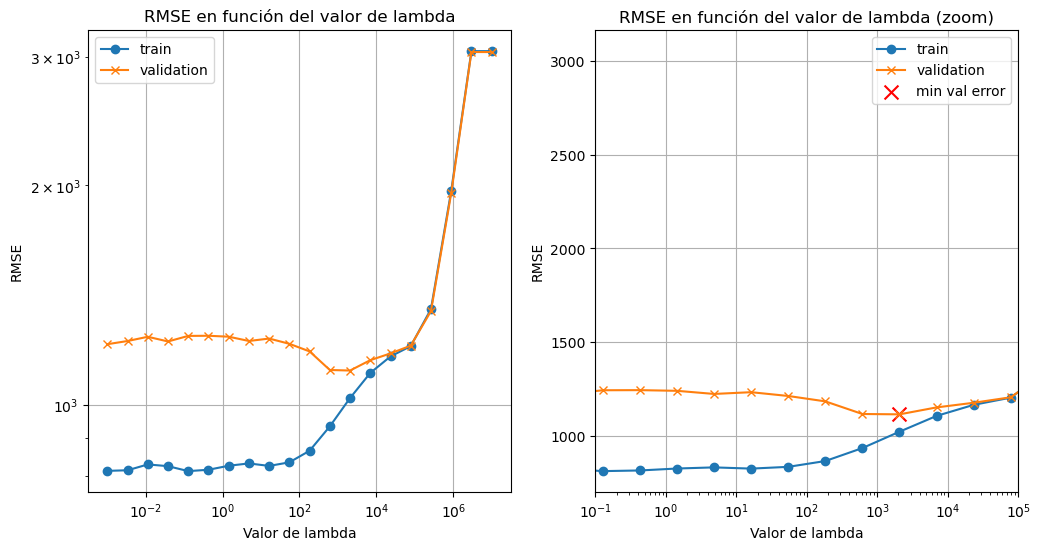

Valor de lambda que minimiza el error de validación: 2069.13808111479
Error de validación mínimo: 1114.2956676367635


In [25]:
# Mostramos la evolución el RMSE en función del valor de lambda
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(lambda_values, train_rmse, label="train", marker='o')
ax[0].plot(lambda_values, val_rmse, label="validation", marker='x')
ax[0].set_xlabel("Valor de lambda")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_ylabel("RMSE")
ax[0].set_title("RMSE en función del valor de lambda")
ax[0].legend()
ax[0].grid()

# Ahora mostraremos un zoom en la zona donde se encuentra el mínimo
ax[1].plot(lambda_values, train_rmse, label="train", marker='o')
ax[1].plot(lambda_values, val_rmse, label="validation", marker='x')
ax[1].scatter(lambda_values[np.argmin(val_rmse)], min(val_rmse), c='red', marker='x', label='min val error', s=100)
ax[1].set_xlabel("Valor de lambda")
ax[1].set_xscale("log")
ax[1].set_ylabel("RMSE")
ax[1].set_title("RMSE en función del valor de lambda (zoom)")
ax[1].legend()
ax[1].grid()
ax[1].set_xlim(1e-1, 1e5)
plt.show()


print("Valor de lambda que minimiza el error de validación:", lambda_values[np.argmin(val_rmse)])
print("Error de validación mínimo:", min(val_rmse))

c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


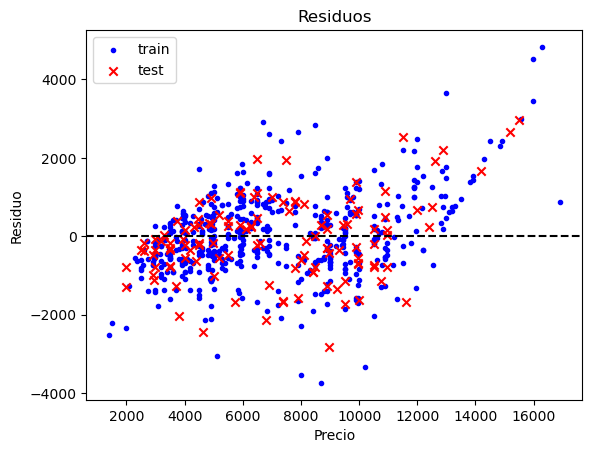

,Label,R2_train,RMSE_train,MRE_train,MAE_train,R2_test,RMSE_test,MRE_test,MAE_test
0,MLPRegressor100Reg,0.888202,1021.137606,0.125917,769.66883,0.887427,1035.560935,0.124318,800.68687


In [26]:
# Entrenamos un modelo con el valor de lambda que minimiza el error de validación
model = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(100,), solver='lbfgs', alpha=lambda_values[np.argmin(val_rmse)], verbose=True, max_iter=1000))
model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
y_pred = model.predict(x_test)

draw_residuals(y_train, y_pred_train, y_test, y_pred, 'Precio', 'Residuo')
addMetricsToResults("MLPRegressor100Reg", y_train, y_pred_train, y_test, y_pred)


### 5.2. Análisis de los resultados

In [27]:
results

,Label,R2_train,RMSE_train,MRE_train,MAE_train,R2_test,RMSE_test,MRE_test,MAE_test
0,LinearRegression(),0.814531,1315.230245,0.166736,996.735227,0.840414,1232.978110,0.140014,870.385627
1,PolynomialRegressionG2,0.854555,1164.704012,0.140712,875.118782,0.865421,1132.262399,0.138410,861.761376
2,PolynomialRegressionG3,0.863136,1129.826167,0.139574,860.701344,0.869789,1113.736369,0.133903,837.468604
3,RidgeRegression,0.864016,1126.187298,0.135634,845.521729,0.867460,1123.650091,0.135471,845.154318
4,LassoRegression,0.870973,1097.001209,0.133534,828.055893,0.872686,1101.274447,0.134420,830.762460
5,MLPRegressor0,0.814531,1315.230245,0.166736,996.735443,0.840414,1232.977957,0.140014,870.385435
6,MLPRegressor100,0.814531,1315.230245,0.166736,996.735443,0.853104,1182.939572,0.156434,901.207507
7,MLPRegressor100Reg,0.888202,1021.137606,0.125917,769.668830,0.887427,1035.560935,0.124318,800.686870


Tal y como se puede ver en la tabla de resultados, este últiom modelo es el mejor de todos los probados. Tiene el las mejores métricas en train y son practicamente iguales en test, por lo que el modelo generaliza bien. Además, el error relativo medio es el menor de todos los modelos probados.

## 6. Conclusiones finales

In [28]:
# Mostramos los resultados ordenados por el error de validación
results.sort_values(by="RMSE_test")

,Label,R2_train,RMSE_train,MRE_train,MAE_train,R2_test,RMSE_test,MRE_test,MAE_test
7,MLPRegressor100Reg,0.888202,1021.137606,0.125917,769.668830,0.887427,1035.560935,0.124318,800.686870
4,LassoRegression,0.870973,1097.001209,0.133534,828.055893,0.872686,1101.274447,0.134420,830.762460
2,PolynomialRegressionG3,0.863136,1129.826167,0.139574,860.701344,0.869789,1113.736369,0.133903,837.468604
3,RidgeRegression,0.864016,1126.187298,0.135634,845.521729,0.867460,1123.650091,0.135471,845.154318
1,PolynomialRegressionG2,0.854555,1164.704012,0.140712,875.118782,0.865421,1132.262399,0.138410,861.761376
6,MLPRegressor100,0.814531,1315.230245,0.166736,996.735443,0.853104,1182.939572,0.156434,901.207507
5,MLPRegressor0,0.814531,1315.230245,0.166736,996.735443,0.840414,1232.977957,0.140014,870.385435
0,LinearRegression(),0.814531,1315.230245,0.166736,996.735227,0.840414,1232.978110,0.140014,870.385627


En esta práctica hemos probado que el modelo de regresión lineal normal y la red neuronal sin capa oculta son iguales, ya que ambos resuelven la ecuación normal y encuentran la solución óptima para la función de coste. Por otro lado, el modelo con capa oculta es un poco mejor que estos anteriores porque consigue aprender relaciones no lineales entre las variables de entrada y la variable de salida.

En cuanto a los modelos polinómicos hemos visto que el los modelos de grado 2 y 3 son prácticamente iguales en test, pero el de grado 2 es más sencillo y por tanto menos propenso a sobreajustar.

Se ha comprobado también como la regularización es un método muy útil para reducir el sobreajuste, ya que ha sido capaz de reducir el error de validación del modelo polinómico de grado 10 al mínimo, consiguiendo que este modelo se comporte prácticamente igual que los modelos de grado 2 y 3. Esto lo ha hecho penalizando más los coeficientes de los términos que no eran de grado 2 y 3 de forma que la función de predicción se ha comportado de forma similar a estos modelos.

Destaca el modelo de red neuronal con capa oculta regularizada que es el mejor de todos los probados. Tiene el las mejores métricas en train y son practicamente iguales en test, por lo que el modelo generaliza bien. Además, el error relativo medio es el menor de todos los modelos probados. Esto se debe a que gracias a su arquitectura ha sido capaz de aprender relaciones no lineales entre las variables de entrada y la variable de salida.

Para seguir mejorando los modelos se podrían introducir más atributos como la marca del vehículo.

### 6.1. Error interesante cometido durante el desarrollo de la práctica


Nota: Durante el desarrollo de la prática se cometió un error y al entrenar los modelos se hacía de esta forma:

```python
    model = make_pipeline(StandardScaler(), PolynomialFeatures(degree=10), Ridge(alpha=lambda_val))
```

En lugar de esta otra forma que es la correcta:

```python
    model = make_pipeline(PolynomialFeatures(degree=10), StandardScaler(), Ridge(alpha=lambda_val))
```

El error se encuentra en que se estandarizan los datos antes de aplicar el polinomio, lo cual no tiene sentido ya que el polinomio aumenta la complejidad del modelo y por tanto el rango de los datos. Al estandarizar los datos antes de aplicar el polinomio se está perdiendo información y por tanto el modelo no se está entrenando correctamente.

Lo que ocurría es que tras varias pruebas los valores de lambda entre los que se encuentraba el mejor valor de regularización eran 1e11 y 1e12, por debajo el error cuadrático medio era muy alto y por encima se estabilizaba en un valor concreto.

Es interesante destacar este fenómeno donde el RMSE se estabiliza a partir de un valor de lambda. Esto se debe a que a partir de un valor de lambda el modelo ya no se está regularizando más por que los valores de sus coeficientes con cercanos a 0 y por tanto el error de validación no disminuye. 
Un valor de lambda demasiado alto hace que el modelo se subajuste y su recta de predicción se convierta en una recta horizontal, tal y como se ve al obtener un r2 de prácticamente 0, predice siempre el mismo valor, el valor medio de la variable de salida.